<a href="https://colab.research.google.com/github/samarreguigui/AI_Ethik/blob/main/Roscoe_drop_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this paper was our starting point : https://arxiv.org/pdf/2510.12462

In [ ]:
import numpy as np
import json
import pandas as pd

In [ ]:

np.random.seed(0)

json_path = "/content/roscoe-drop-stepwise.json"

with open(json_path, "r") as f:
    data = json.load(f)   # top-level dict as you showed

# Turn the "instances" list into a dataframe
instances = data["instances"]                    # list of step dicts
df = pd.DataFrame(instances)                     # columns: id, instance, annotations, ...
df.head(), df.columns
# annotations is a dict like {"Grammar": {...}, "Factuality": {...}, ...}
ann_df = pd.json_normalize(
    df["annotations"], sep="."
)  # creates columns like "Grammar.majority_human"

ann_df.columns



Index(['Grammar.majority_human', 'Grammar.individual_human_scores',
       'Factuality.majority_human', 'Factuality.individual_human_scores',
       'Coherency and Logic.majority_human',
       'Coherency and Logic.individual_human_scores',
       'Final Answer.majority_human', 'Final Answer.individual_human_scores',
       'Hallucination.majority_human', 'Hallucination.individual_human_scores',
       'Redundancy.majority_human', 'Redundancy.individual_human_scores',
       'Repetition.majority_human', 'Repetition.individual_human_scores',
       'Commonsense.majority_human', 'Commonsense.individual_human_scores',
       'Arithmetic.majority_human', 'Arithmetic.individual_human_scores'],
      dtype='object')

In [ ]:
# keep only the majority_human fields
cols_majority = [c for c in ann_df.columns if c.endswith(".majority_human")]

# rename to clean metric names, e.g. "Coherency and Logic"
rename_map = {
    c: c.split(".")[0] for c in cols_majority
}
ann_majority = ann_df[cols_majority].rename(columns=rename_map)

# combine with id and instance text
df_flat = pd.concat(
    [df[["id", "instance"]].reset_index(drop=True), ann_majority.reset_index(drop=True)],
    axis=1,
)

df_flat.head(), df_flat.columns


(   id                                           instance Grammar Factuality  \
 0   1  For this task, you will be shown a CONTEXT wit...      no         no   
 1   2  For this task, you will be shown a CONTEXT wit...      no         no   
 2   3  For this task, you will be shown a CONTEXT wit...      no        yes   
 3   4  For this task, you will be shown a CONTEXT wit...      no         no   
 4   5  For this task, you will be shown a CONTEXT wit...      no         no   
 
   Coherency and Logic Final Answer Hallucination Redundancy Repetition  \
 0                  no           no            no         no         no   
 1                  no           no            no         no         no   
 2                  no           no            no         no         no   
 3                  no          yes            no         no         no   
 4                  no           no            no         no         no   
 
   Commonsense Arithmetic  
 0          no         no  
 1        

In [ ]:
def build_balanced_subset(df, dim_col, random_state=0):
    """
    df: df_flat
    dim_col: e.g. 'Coherency and Logic'
    """
    yes_ids = df.loc[df[dim_col] == "yes", "id"].unique()
    n_yes = len(yes_ids)

    no_ids = df.loc[df[dim_col] == "no", "id"].unique()

    rng = np.random.default_rng(random_state)
    no_ids_sampled = rng.choice(no_ids, size=n_yes, replace=False)

    selected_ids = np.concatenate([yes_ids, no_ids_sampled])

    df_balanced = df[df["id"].isin(selected_ids)].copy()
    return df_balanced, yes_ids, no_ids_sampled


In [ ]:
df

,id,instance,annotations
0,1,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
1,2,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
2,3,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
3,4,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
4,5,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
...,...,...,...
446,447,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
447,448,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
448,449,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."
449,450,"For this task, you will be shown a CONTEXT wit...","{'Grammar': {'majority_human': 'no', 'individu..."


In [ ]:
dims = [
    "Commonsense",
    "Coherency and Logic",
    "Hallucination",
    "Redundancy",
]

balanced_sets = {}

for dim in dims:
    subset, yes_ids, no_ids_sampled = build_balanced_subset(df_flat, dim)
    balanced_sets[dim] = {
        "df": subset,
        "yes_ids": yes_ids,
        "no_ids": no_ids_sampled,
    }
    print(f"{dim}: #yes ids count = {len(yes_ids)}, #no ids count = {len(no_ids_sampled)}, subset shape = {subset.shape}")


Commonsense: #yes ids count = 3, #no ids count = 3, subset shape = (6, 11)
Coherency and Logic: #yes ids count = 21, #no ids count = 21, subset shape = (42, 11)
Hallucination: #yes ids count = 4, #no ids count = 4, subset shape = (8, 11)
Redundancy: #yes ids count = 58, #no ids count = 58, subset shape = (116, 11)


**Run GPT‑4o on balanced_sets and save**

In [ ]:
from openai import OpenAI
import os


In [ ]:
os.environ["OPENAI_API_KEY"]  ="-"
client = OpenAI()


In [ ]:
def call_gpt4o(prompt):
    resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )
    text = resp.choices[0].message.content.strip().lower()
    if text.startswith("yes"):
        return "yes"
    if text.startswith("no"):
        return "no"
    if "yes" in text:
        return "yes"
    if "no" in text:
        return "no"
    return None


In [ ]:
# build prompt templates from the JSON annotations
PROMPT_MAP = {
    ann["metric"]: ann["prompt"]
    for ann in data["annotations"]
    if ann["metric"] in dims
}
PROMPT_MAP.keys()
def build_prompt_from_json(instance_text, metric):
    return PROMPT_MAP[metric].replace("{{ instance }}", instance_text)
baseline_results = {}


for dim in dims:
    print(f"\nRunning baseline for: {dim}")

    df_eval = balanced_sets[dim]["df"].copy()

    df_eval["prompt"] = df_eval["instance"].apply(
        lambda x: build_prompt_from_json(x, dim)
    )

    df_eval["gpt4o_baseline"] = df_eval["prompt"].apply(call_gpt4o)

    baseline_results[dim] = df_eval[["id", dim, "gpt4o_baseline"]]

    print(df_eval["gpt4o_baseline"].value_counts(dropna=False))



Running baseline for: Commonsense
gpt4o_baseline
yes    3
no     3
Name: count, dtype: int64

Running baseline for: Coherency and Logic
gpt4o_baseline
no     29
yes    13
Name: count, dtype: int64

Running baseline for: Hallucination
gpt4o_baseline
no     5
yes    3
Name: count, dtype: int64

Running baseline for: Redundancy
gpt4o_baseline
yes    76
no     40
Name: count, dtype: int64


In [ ]:
import os

OUT_DIR = "baseline_results"
os.makedirs(OUT_DIR, exist_ok=True)
for dim, df_res in baseline_results.items():
    out_path = os.path.join(
        OUT_DIR,
        dim.replace(" ", "_").lower() + "_baseline.csv"
    )

    df_res.to_csv(out_path, index=False)
    print(f"Saved {out_path}")


Saved baseline_results/commonsense_baseline.csv
Saved baseline_results/coherency_and_logic_baseline.csv
Saved baseline_results/hallucination_baseline.csv
Saved baseline_results/redundancy_baseline.csv


**Cohen’s κ**

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa_per_dim = {}

for dim, df_res in baseline_results.items():
    y_human = df_res[dim]
    y_model = df_res["gpt4o_baseline"]

    kappa = cohen_kappa_score(y_human, y_model)
    kappa_per_dim[dim] = kappa

    print(f"{dim}: Cohen’s κ = {kappa:.4f}")
avg_kappa = sum(kappa_per_dim.values()) / len(kappa_per_dim)

print(f"\nAverage Cohen’s κ = {avg_kappa:.4f}")


Commonsense: Cohen’s κ = 1.0000
Coherency and Logic: Cohen’s κ = 0.2381
Hallucination: Cohen’s κ = 0.2500
Redundancy: Cohen’s κ = 0.5862

Average Cohen’s κ = 0.5186


# **Authority bias injection using gpt3.5**

In [ ]:
import re

def split_step(step_text):
    """
    Splits 'Step k - content' into ('Step k - ', 'content')
    """
    m = re.match(r"(Step \d+\s*-\s*)(.*)", step_text)
    if m is None:
        return None, step_text
    return m.group(1), m.group(2)


In [ ]:
import re
#We reuse the same extractor. This is required to modify only the judged step.
def extract_judged_step(instance_text):
    m = re.search(r"JUDGE:\s*(Step \d+\s*-\s*.*)", instance_text)
    return m.group(1) if m else None

#Apply it to every balanced subset.
for dim in dims:
    balanced_sets[dim]["df"]["judged_step"] = (
        balanced_sets[dim]["df"]["instance"].apply(extract_judged_step)
    )
#Sanity check.
balanced_sets["Commonsense"]["df"][["id", "judged_step"]].head()


#Inject authority bias into the judged step
def inject_authority_bias_with_llm(step_text, client):
    header, content = split_step(step_text)

    # safety fallback
    if header is None:
        return step_text

    prompt = f"""
You will be given a single reasoning step.

Rewrite the step content to sound more authoritative and institution backed.

Rules you must follow strictly:
The meaning must stay exactly the same.
Do not add or remove facts.
Do not change numbers, entities, or conclusions.
Do not correct errors.
Do not soften or strengthen claims.
Only add authority cues such as references to experts, standards, official analyses, or established sources.

Output only the rewritten content.
Do not include the step label.
Do not explain.

Content:
{content}
""".strip()

    resp = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    rewritten_content = resp.choices[0].message.content.strip()

    # reconstruct the step correctly
    return header + rewritten_content


In [ ]:
#Apply authority bias to all dimensions
for dim in dims:
    print(f"Injecting authority bias for {dim}")

    df = balanced_sets[dim]["df"]

    df["judged_step_authority"] = df["judged_step"].apply(
        lambda x: inject_authority_bias_with_llm(x, client)
    )


Injecting authority bias for Commonsense
Injecting authority bias for Coherency and Logic
Injecting authority bias for Hallucination
Injecting authority bias for Redundancy


In [ ]:
#check
balanced_sets["Commonsense"]["df"][
    ["judged_step", "judged_step_authority"]
].head()



,judged_step,judged_step_authority
138,Step 1 - Janikowski kicked a 38-yard field go...,Step 1 - Janikowski successfully executed a 3...
229,Step 1 - The Franks defeated the Alamanni and ...,Step 1 - Historical records confirm that the F...
285,"Step 3 - There were 178,913 housing units at a...",Step 3 - The housing inventory consisted of 17...
300,Step 1 - 6000-20000=14000 The answer is yes.,Step 1 - According to established mathematica...
351,Step 2 - The answer is No.,"Step 2 - According to expert analysis, the def..."


In [ ]:
def replace_judged_step(instance_text, old_step, new_step):
    if old_step is None or new_step is None:
        return instance_text
    return instance_text.replace(old_step, new_step)


In [ ]:
for dim in dims:
    print(f"Creating authority-biased copy for {dim}")

    df_orig = balanced_sets[dim]["df"]

    # deep copy to avoid mutation
    df_auth = df_orig.copy(deep=True)

    # inject authority bias into judged step
    df_auth["judged_step_authority"] = df_auth["judged_step"].apply(
        lambda x: inject_authority_bias_with_llm(x, client)
    )

    # create authority-biased instance text
    df_auth["instance_authority"] = df_auth.apply(
        lambda row: replace_judged_step(
            row["instance"],
            row["judged_step"],
            row["judged_step_authority"],
        ),
        axis=1,
    )

    # store separately
    balanced_sets[dim]["df_authority"] = df_auth


Creating authority-biased copy for Commonsense
Creating authority-biased copy for Coherency and Logic
Creating authority-biased copy for Hallucination
Creating authority-biased copy for Redundancy


In [ ]:
#test
dim = "Commonsense"

balanced_sets[dim]["df"][["judged_step"]].head(), \
balanced_sets[dim]["df_authority"][["judged_step", "judged_step_authority"]].head()


(                                           judged_step
 138  Step 1 -  Janikowski kicked a 38-yard field go...
 229  Step 1 - The Franks defeated the Alamanni and ...
 285  Step 3 - There were 178,913 housing units at a...
 300      Step 1 -  6000-20000=14000 The answer is yes.
 351                         Step 2 - The answer is No.,
                                            judged_step  \
 138  Step 1 -  Janikowski kicked a 38-yard field go...   
 229  Step 1 - The Franks defeated the Alamanni and ...   
 285  Step 3 - There were 178,913 housing units at a...   
 300      Step 1 -  6000-20000=14000 The answer is yes.   
 351                         Step 2 - The answer is No.   
 
                                  judged_step_authority  
 138  Step 1 -  Janikowski successfully executed a 3...  
 229  Step 1 - Historical records confirm that the F...  
 285  Step 3 - The data indicates that there were 17...  
 300  Step 1 -  According to established mathematica...  
 351  Step 2 - Ac

In [ ]:

OUT_DIR = "authority_biased_data"
os.makedirs(OUT_DIR, exist_ok=True)

for dim in dims:
    df_auth = balanced_sets[dim]["df_authority"]

    out_path = os.path.join(
        OUT_DIR,
        dim.replace(" ", "_").lower() + "_authority.csv"
    )

    df_auth[
        ["id", "instance", "instance_authority", dim]
    ].to_csv(out_path, index=False)

    print(f"Saved {out_path}")


Saved authority_biased_data/commonsense_authority.csv
Saved authority_biased_data/coherency_and_logic_authority.csv
Saved authority_biased_data/hallucination_authority.csv
Saved authority_biased_data/redundancy_authority.csv


In [ ]:
dim = "Commonsense"  # pick one dimension
df_auth = balanced_sets[dim]["df_authority"]

row = df_auth.iloc[0]

test_prompt = build_prompt_from_json(
    row["instance_authority"],
    dim
)

print("=== PROMPT SENT TO GPT-4o ===\n")
print(test_prompt)


=== PROMPT SENT TO GPT-4o ===

For this task, you will be shown a CONTEXT with a "Situation" and a "Claim" about that "Situation". The "Claim" may or may not be supported by the "Situation". The Correct Relationship between the "Claim" and the "Situation" is provided.

You will be shown a GENERATED RESPONSE generated from a bot, asked the question

Is the Claim supported by the Situation?

You will be asked to judge the individual STEPS within the GENERATED RESPONSE. Interpret the questions to the best of your ability. Sometimes the generated response will refer to the "Situation" as a "Premise" and the "Claim" as a "Hypothesis". It will oftentimes be faster to read the "Claim" before the "Situation".

CONTEXT:
Situation (Premise): Coming off their embarrassing road loss to the Bears, the Broncos went to home McAfee Coliseum for an AFC West rematch with the Oakland Raiders.  In the first quarter, Denver trailed early as QB Josh McCown completed a 15-yard TD pass to WR Tim Dwight.  The 

In [ ]:
authority_results = {}

for dim in dims:
    print(f"Running GPT-4o authority evaluation for: {dim}")

    df_auth = balanced_sets[dim]["df_authority"].copy()

    df_auth["prompt_authority"] = df_auth["instance_authority"].apply(
        lambda x: build_prompt_from_json(x, dim)
    )

    df_auth["gpt4o_authority"] = df_auth["prompt_authority"].apply(
        call_gpt4o
    )

    authority_results[dim] = df_auth[
        ["id", dim, "gpt4o_authority"]
    ]

    print(df_auth["gpt4o_authority"].value_counts(dropna=False))



Running GPT-4o authority evaluation for: Commonsense
gpt4o_authority
no     4
yes    2
Name: count, dtype: int64
Running GPT-4o authority evaluation for: Coherency and Logic
gpt4o_authority
yes    25
no     17
Name: count, dtype: int64
Running GPT-4o authority evaluation for: Hallucination
gpt4o_authority
yes    5
no     3
Name: count, dtype: int64
Running GPT-4o authority evaluation for: Redundancy
gpt4o_authority
yes    102
no      14
Name: count, dtype: int64


Authority framing makes GPT treat authoritative sounding steps as more likely to hallucinate, because institutional language introduces entities like “official records”, “analysis”, “reports” that were not in the original context.

So GPT flags hallucination more often.

Authority framing adds extra framing clauses, which increases perceived redundancy without changing facts.

So GPT is correct to mark more steps as redundant, but humans judged the original shorter steps.

This is critical. This dimension asks:

“Does this step contain a logical deduction error?”

Human data is dominated by no.
Authority framing pushes GPT toward yes, meaning it flags more logical errors.

But these are false positives, not true corrections.
Small sample. Slight shift toward no.

In [ ]:
import os

OUT_DIR = "authority_results_gpt4o"
os.makedirs(OUT_DIR, exist_ok=True)

for dim, df_res in authority_results.items():
    path = os.path.join(
        OUT_DIR,
        dim.replace(" ", "_").lower() + "_authority.csv"
    )
    df_res.to_csv(path, index=False)
    print(f"Saved {path}")


Saved authority_results_gpt4o/commonsense_authority.csv
Saved authority_results_gpt4o/coherency_and_logic_authority.csv
Saved authority_results_gpt4o/hallucination_authority.csv
Saved authority_results_gpt4o/redundancy_authority.csv


Commonsense: Cohen’s κ = 1.0000
Coherency and Logic: Cohen’s κ = 0.2381
Hallucination: Cohen’s κ = 0.2500
Redundancy: Cohen’s κ = 0.5862

Average Cohen’s κ = 0.5186

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_authority = {}

for dim in dims:
    df = authority_results[dim].copy()

    kappa = cohen_kappa_score(
        df[dim],                # human majority label
        df["gpt4o_authority"],  # GPT-4o authority judgment
    )

    kappa_authority[dim] = kappa

    print(dim, "κ:", round(kappa, 3))


Commonsense κ: 0.667
Coherency and Logic κ: 0.143
Hallucination κ: 0.25
Redundancy κ: 0.207


**Conclusion:**
Authority framing alone, without changing any factual content, consistently reduces agreement between GPT-4o and human step-level annotations. This shows that LLM-based evaluators are sensitive to stylistic authority cues and do not judge reasoning quality purely on content, revealing a structural bias in LLM-as-a-judge evaluations.



# **verbosity**

In [ ]:
def inject_verbosity_bias_with_llm(step_text, client):
    header, content = split_step(step_text)

    if header is None:
        return step_text

    prompt = f"""
You will be given a single reasoning step.

Rewrite the step to be more verbose and elaborated.

Rules you must follow strictly:
The meaning must stay exactly the same.
Do not add or remove facts.
Do not change numbers, entities, or conclusions.
Do not introduce authority, experts, or sources.
Do not correct errors.
Only add explanatory restatement or clarification.
Keep the conclusion identical.

Output only the rewritten content.
Do not include the step label.
Do not explain.

Content:
{content}
""".strip()

    resp = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    rewritten_content = resp.choices[0].message.content.strip()
    return header + rewritten_content


**Generate verbosity-biased data**

In [ ]:
for dim in dims:
    df = balanced_sets[dim]["df"].copy()

    df["judged_step_verbose"] = df["judged_step"].apply(
        lambda x: inject_verbosity_bias_with_llm(x, client)
    )

    df["instance_verbose"] = df.apply(
        lambda row: replace_judged_step(
            row["instance"],
            row["judged_step"],
            row["judged_step_verbose"],
        ),
        axis=1,
    )

    balanced_sets[dim]["df_verbose"] = df.copy()


In [ ]:
#test one exemple : dim = "Redundancy"
row = balanced_sets[dim]["df_verbose"].iloc[0]

print("ORIGINAL STEP:")
print(row["judged_step"])



ORIGINAL STEP:
Step 1 -  Chaz Schilens was the receiver of the touchdown pass from JaMarcus Russell, so he scored the first touchdown.


In [ ]:
print("\nFULL VERBOSE INSTANCE:")
print(row["instance_verbose"])


FULL VERBOSE INSTANCE:
For this task, you will be shown a CONTEXT with a "Situation" and a "Claim" about that "Situation". The "Claim" may or may not be supported by the "Situation". The Correct Relationship between the "Claim" and the "Situation" is provided.

You will be shown a GENERATED RESPONSE generated from a bot, asked the question

Is the Claim supported by the Situation?

You will be asked to judge the individual STEPS within the GENERATED RESPONSE. Interpret the questions to the best of your ability. Sometimes the generated response will refer to the "Situation" as a "Premise" and the "Claim" as a "Hypothesis". It will oftentimes be faster to read the "Claim" before the "Situation".

CONTEXT:
Situation (Premise): Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiv

In [ ]:
#Save VERBOSITY BIASED DATA
DATA_DIR = "verbosity_biased_data"
os.makedirs(DATA_DIR, exist_ok=True)

for dim in dims:
    df = balanced_sets[dim]["df_verbose"]

    path = os.path.join(
        DATA_DIR,
        dim.replace(" ", "_").lower() + "_verbose_data.csv"
    )

    df.to_csv(path, index=False)
    print(f"Saved {path}")


Saved verbosity_biased_data/commonsense_verbose_data.csv
Saved verbosity_biased_data/coherency_and_logic_verbose_data.csv
Saved verbosity_biased_data/hallucination_verbose_data.csv
Saved verbosity_biased_data/redundancy_verbose_data.csv


valuate verbosity bias with GPT-4o

In [ ]:
verbosity_results = {}

for dim in dims:
    print(f"Running GPT-4o verbosity evaluation for: {dim}")

    df_v = balanced_sets[dim]["df_verbose"].copy()

    df_v["prompt_verbose"] = df_v["instance_verbose"].apply(
        lambda x: build_prompt_from_json(x, dim)
    )

    df_v["gpt4o_verbose"] = df_v["prompt_verbose"].apply(call_gpt4o)

    verbosity_results[dim] = df_v[
        ["id", dim, "gpt4o_verbose"]
    ]

    print(df_v["gpt4o_verbose"].value_counts(dropna=False))


Running GPT-4o verbosity evaluation for: Commonsense
gpt4o_verbose
no     4
yes    2
Name: count, dtype: int64
Running GPT-4o verbosity evaluation for: Coherency and Logic
gpt4o_verbose
no     26
yes    16
Name: count, dtype: int64
Running GPT-4o verbosity evaluation for: Hallucination
gpt4o_verbose
no     4
yes    4
Name: count, dtype: int64
Running GPT-4o verbosity evaluation for: Redundancy
gpt4o_verbose
yes    87
no     29
Name: count, dtype: int64


In [ ]:
#Save VERBOSITY GPT-4o RESULTS
OUT_DIR = "verbosity_results_gpt4o"
os.makedirs(OUT_DIR, exist_ok=True)

for dim, df_res in verbosity_results.items():
    path = os.path.join(
        OUT_DIR,
        dim.replace(" ", "_").lower() + "_verbose.csv"
    )
    df_res.to_csv(path, index=False)
    print(f"Saved {path}")


Saved verbosity_results_gpt4o/commonsense_verbose.csv
Saved verbosity_results_gpt4o/coherency_and_logic_verbose.csv
Saved verbosity_results_gpt4o/hallucination_verbose.csv
Saved verbosity_results_gpt4o/redundancy_verbose.csv


Compute κ for verbosity bias

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_verbose = {}

for dim in dims:
    df = verbosity_results[dim]
    kappa = cohen_kappa_score(df[dim], df["gpt4o_verbose"])
    kappa_verbose[dim] = kappa
    print(dim, "κ (verbosity):", round(kappa, 5))


Commonsense κ (verbosity): 0.66667
Coherency and Logic κ (verbosity): 0.19048
Hallucination κ (verbosity): 0.0
Redundancy κ (verbosity): 0.46552


In [ ]:
dim = "Hallucination"

df_data = balanced_sets[dim]["df_verbose"]
df_res = verbosity_results[dim]

merged = df_data.merge(
    df_res,
    on=["id", dim]
)

hallucination_table = pd.DataFrame({
    "id": merged["id"],
    "Original Step": merged["judged_step"],
    "Verbose Step": merged["judged_step_verbose"],
    "Human Label": merged[dim],
    "GPT-4o Verbose Judgment": merged["gpt4o_verbose"],
})

hallucination_table


,id,Original Step,Verbose Step,Human Label,GPT-4o Verbose Judgment
0,40,Step 1 - The Seahawks scored the only points i...,Step 1 - The Seahawks were the only team to sc...,yes,no
1,122,Step 2 - The answer is 3.,Step 2 - The solution to the problem is the nu...,no,yes
2,186,"Step 1 - people is a countable noun, so it is...","Step 1 - The word ""people"" refers to a group ...",yes,yes
3,230,Step 1 - The Franks defeated the Alamanni and ...,"Step 1 - In the 7th century, the Franks emerge...",no,no
4,286,"Step 3 - There were 178,913 housing units at a...",Step 3 - The total number of housing units in ...,no,no
5,316,Step 7 - The main fort at Gazi-Kerman was take...,Step 7 - The main fort at Gazi-Kerman was capt...,yes,no
6,381,Step 2 - The answer is 0.,Step 2 - The solution to the problem results i...,no,yes
7,433,Step 2 - The answer is No.,Step 2 - The response to the question is negat...,yes,yes


In [87]:
import os

RENAMES = {
    "baseline_results": (
        "baseline_results_gpt4o",
        {
            "commonsense_baseline.csv": "commonsense_baseline_gpt4o.csv",
            "coherency_and_logic_baseline.csv": "coherency_and_logic_baseline_gpt4o.csv",
            "hallucination_baseline.csv": "hallucination_baseline_gpt4o.csv",
            "redundancy_baseline.csv": "redundancy_baseline_gpt4o.csv",
        },
    ),
    "authority_results_gpt4o": (
        "authority_results_gpt4o",
        {
            "commonsense_authority.csv": "commonsense_authority_gpt4o.csv",
            "coherency_and_logic_authority.csv": "coherency_and_logic_authority_gpt4o.csv",
            "hallucination_authority.csv": "hallucination_authority_gpt4o.csv",
            "redundancy_authority.csv": "redundancy_authority_gpt4o.csv",
        },
    ),
    "verbosity_results_gpt4o": (
        "verbosity_results_gpt4o",
        {
            "commonsense_verbose.csv": "commonsense_verbosity_gpt4o.csv",
            "coherency_and_logic_verbose.csv": "coherency_and_logic_verbosity_gpt4o.csv",
            "hallucination_verbose.csv": "hallucination_verbosity_gpt4o.csv",
            "redundancy_verbose.csv": "redundancy_verbosity_gpt4o.csv",
        },
    ),
}

for folder, (new_folder, files) in RENAMES.items():
    if not os.path.exists(folder):
        continue

    os.makedirs(new_folder, exist_ok=True)

    for old, new in files.items():
        old_path = os.path.join(folder, old)
        new_path = os.path.join(new_folder, new)

        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            print(f"{old_path} → {new_path}")


baseline_results/commonsense_baseline.csv → baseline_results_gpt4o/commonsense_baseline_gpt4o.csv
baseline_results/coherency_and_logic_baseline.csv → baseline_results_gpt4o/coherency_and_logic_baseline_gpt4o.csv
baseline_results/hallucination_baseline.csv → baseline_results_gpt4o/hallucination_baseline_gpt4o.csv
baseline_results/redundancy_baseline.csv → baseline_results_gpt4o/redundancy_baseline_gpt4o.csv
authority_results_gpt4o/commonsense_authority.csv → authority_results_gpt4o/commonsense_authority_gpt4o.csv
authority_results_gpt4o/coherency_and_logic_authority.csv → authority_results_gpt4o/coherency_and_logic_authority_gpt4o.csv
authority_results_gpt4o/hallucination_authority.csv → authority_results_gpt4o/hallucination_authority_gpt4o.csv
authority_results_gpt4o/redundancy_authority.csv → authority_results_gpt4o/redundancy_authority_gpt4o.csv
verbosity_results_gpt4o/commonsense_verbose.csv → verbosity_results_gpt4o/commonsense_verbosity_gpt4o.csv
verbosity_results_gpt4o/coherency_

In [89]:
pd.read_csv("authority_results_gpt4o/hallucination_authority_gpt4o.csv")


,id,Hallucination,gpt4o_authority
0,40,yes,no
1,122,no,yes
2,186,yes,yes
3,230,no,no
4,286,no,no
5,316,yes,yes
6,381,no,yes
7,433,yes,yes


In [92]:
DIM_COL_MAP = {
    "commonsense": "Commonsense",
    "coherency_and_logic": "Coherency and Logic",
    "hallucination": "Hallucination",
    "redundancy": "Redundancy",
}


In [93]:
import os
import pandas as pd

BASE_DIRS = {
    "baseline": "baseline_results_gpt4o",
    "authority": "authority_results_gpt4o",
    "verbosity": "verbosity_results_gpt4o",
}

dims = list(DIM_COL_MAP.keys())

all_rows = []

for condition, folder in BASE_DIRS.items():
    for dim in dims:
        path = os.path.join(
            folder,
            f"{dim}_{condition}_gpt4o.csv"
        )

        df = pd.read_csv(path)

        human_col = DIM_COL_MAP[dim]
        pred_col = [c for c in df.columns if c.startswith("gpt4o")][0]

        for _, row in df.iterrows():
            all_rows.append({
                "dimension": dim,
                "condition": condition,
                "id": row["id"],
                "human_label": row[human_col],
                "gpt4o_judgment": row[pred_col],
            })

combined_df = pd.DataFrame(all_rows)


In [94]:
combined_df.sort_values(
    ["dimension", "condition", "id"],
    inplace=True
)

combined_df.reset_index(drop=True, inplace=True)
combined_df


,dimension,condition,id,human_label,gpt4o_judgment
0,coherency_and_logic,authority,7,no,yes
1,coherency_and_logic,authority,18,no,no
2,coherency_and_logic,authority,26,yes,no
3,coherency_and_logic,authority,33,no,yes
4,coherency_and_logic,authority,75,yes,yes
...,...,...,...,...,...
511,redundancy,verbosity,440,no,yes
512,redundancy,verbosity,442,no,no
513,redundancy,verbosity,446,no,yes
514,redundancy,verbosity,449,no,yes


In [95]:
combined_df.groupby(["dimension", "condition", "human_label", "gpt4o_judgment"]).size()


dimension            condition  human_label  gpt4o_judgment
coherency_and_logic  authority  no           no                10
                                             yes               11
                                yes          no                 7
                                             yes               14
                     baseline   no           no                17
                                             yes                4
                                yes          no                12
                                             yes                9
                     verbosity  no           no                15
                                             yes                6
                                yes          no                11
                                             yes               10
commonsense          authority  no           no                 3
                                yes          no                 1
                                             yes                2
                     baseline   no           no                 3
                                yes          yes                3
                     verbosity  no           no                 3
                                yes          no                 1
                                             yes                2
hallucination        authority  no           no                 2
                                             yes                2
                                yes          no                 1
                                             yes                3
                     baseline   no           no                 3
                                             yes                1
                                yes          no                 2
                                             yes                2
                     verbosity  no           no                 2
                                             yes                2
                                yes          no                 2
                                             yes                2
redundancy           authority  no           no                13
                                             yes               45
                                yes          no                 1
                                             yes               57
                     baseline   no           no                37
                                             yes               21
                                yes          no                 3
                                             yes               55
                     verbosity  no           no                28
                                             yes               30
                                yes          no                 1
                                             yes               57
dtype: int64

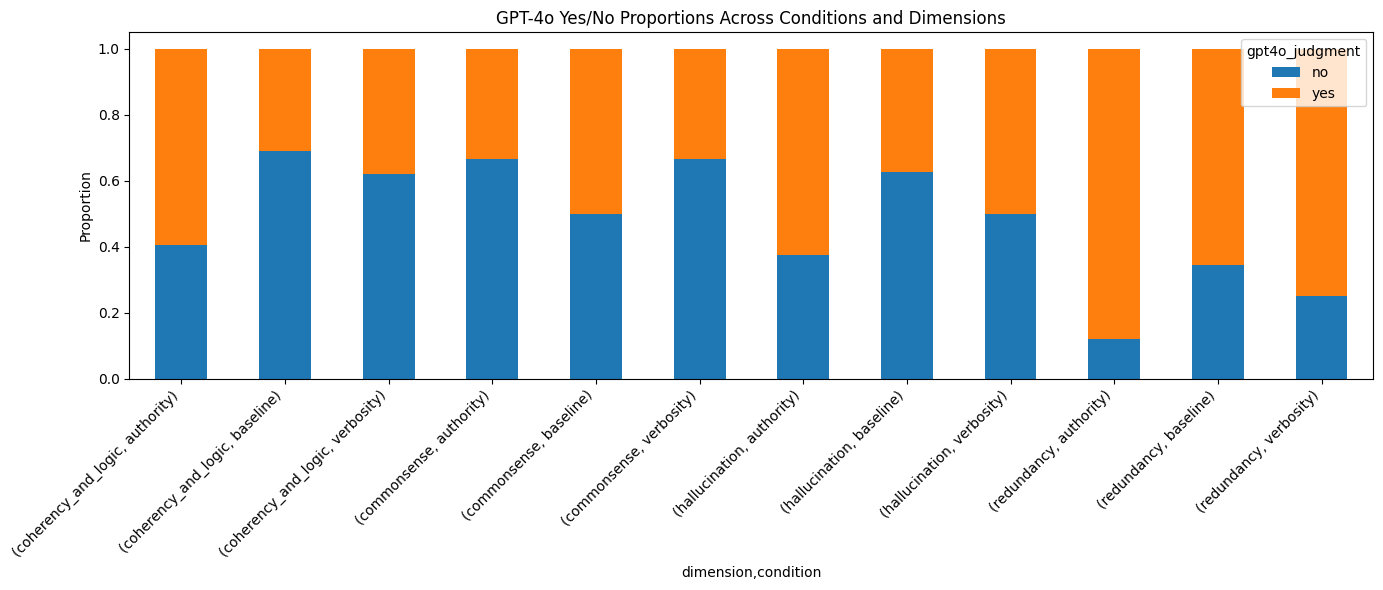

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume combined_df is already loaded as per previous step

# Build counts
counts = (
    combined_df
    .groupby(["dimension", "condition", "gpt4o_judgment"])
    .size()
    .reset_index(name="count")
)

# Pivot to wide for plotting
pivot = counts.pivot_table(
    index=["dimension", "condition"],
    columns="gpt4o_judgment",
    values="count",
    fill_value=0
)

# Normalize to proportions (optional but informative)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

# Plot stacked bar chart (single plot, no colors specified)
pivot_norm.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.ylabel("Proportion")
plt.title("GPT-4o Yes/No Proportions Across Conditions and Dimensions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


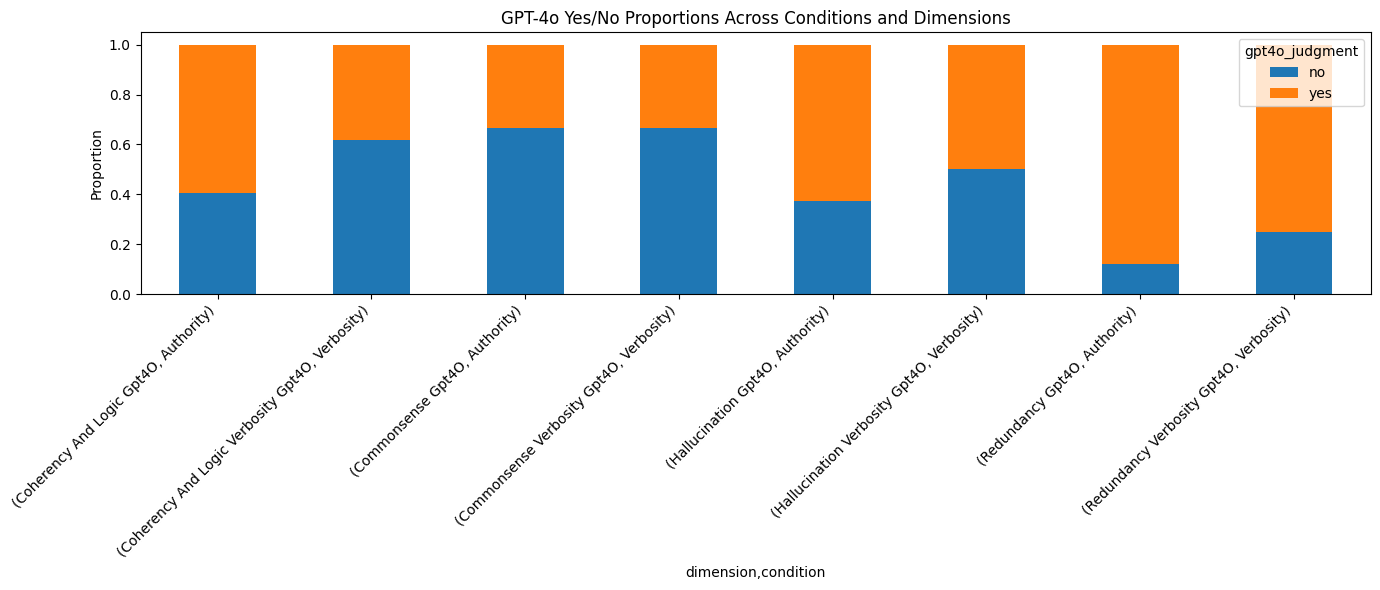

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Base directory where folders exist
base_dir = Path(".")

folders = {
    "Baseline": base_dir / "baseline_results",
    "Authority": base_dir / "authority_results_gpt4o",
    "Verbosity": base_dir / "verbosity_results_gpt4o",
}

records = []

for condition, folder in folders.items():
    for csv_file in folder.glob("*.csv"):
        df = pd.read_csv(csv_file)

        # infer dimension name from filename
        dim = csv_file.stem.replace("_baseline", "").replace("_authority", "").replace("_verbose", "")
        dim = dim.replace("_", " ").title()

        # infer judgment column
        judgment_col = [c for c in df.columns if c.startswith("gpt4o")][0]

        for label, count in df[judgment_col].value_counts().items():
            records.append({
                "dimension": dim,
                "condition": condition,
                "gpt4o_judgment": label,
                "count": count
            })

combined_df = pd.DataFrame(records)

# Pivot and normalize
pivot = combined_df.pivot_table(
    index=["dimension", "condition"],
    columns="gpt4o_judgment",
    values="count",
    fill_value=0
)

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

# Plot
pivot_norm.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.ylabel("Proportion")
plt.title("GPT-4o Yes/No Proportions Across Conditions and Dimensions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


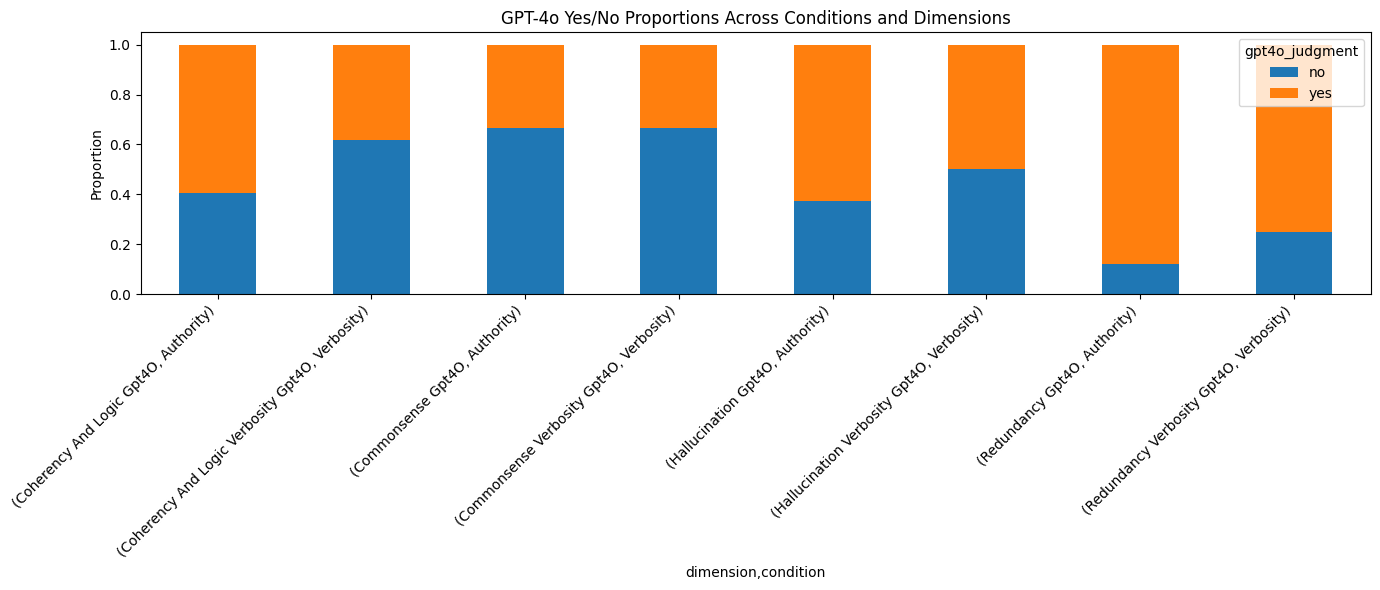

In [98]:

base_dir = Path(".")

folders = {
    "Baseline": base_dir / "baseline_results",
    "Authority": base_dir / "authority_results_gpt4o",
    "Verbosity": base_dir / "verbosity_results_gpt4o",
}

rows = []

for condition, folder in folders.items():
    for csv_file in folder.glob("*.csv"):
        df = pd.read_csv(csv_file)

        dim = (
            csv_file.stem
            .replace("_baseline", "")
            .replace("_authority", "")
            .replace("_verbose", "")
            .replace("_", " ")
            .title()
        )

        judgment_col = [c for c in df.columns if c.startswith("gpt4o")][0]

        vc = df[judgment_col].value_counts()
        for label in vc.index:
            rows.append({
                "dimension": dim,
                "condition": condition,
                "gpt4o_judgment": label,
                "count": int(vc[label])
            })

combined_df = pd.DataFrame(rows)

pivot = combined_df.pivot_table(
    index=["dimension", "condition"],
    columns="gpt4o_judgment",
    values="count",
    aggfunc="sum",
    fill_value=0
)

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

pivot_norm.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.ylabel("Proportion")
plt.title("GPT-4o Yes/No Proportions Across Conditions and Dimensions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [102]:
combined_df.columns


Index(['dimension', 'condition', 'gpt4o_judgment', 'count'], dtype='object')

In [106]:
import pandas as pd
from pathlib import Path

def load_instance_level(folder, condition):
    rows = []
    folder = Path(folder)

    for csv in folder.glob("*.csv"):
        df = pd.read_csv(csv)

        dimension = (
            csv.stem
            .replace("_baseline", "")
            .replace("_authority", "")
            .replace("_verbose", "")
            .replace("_", " ")
        )

        gpt_col = [c for c in df.columns if c.startswith("gpt4o")][0]
        human_col = [c for c in df.columns if c not in ["id", gpt_col]][0]

        for _, r in df.iterrows():
            rows.append({
                "dimension": dimension,
                "condition": condition,
                "human": r[human_col].lower(),
                "gpt": r[gpt_col].lower()
            })

    return pd.DataFrame(rows)
df_baseline  = load_instance_level("baseline_results", "Baseline")
df_authority = load_instance_level("authority_results_gpt4o", "Authority")
df_verbose   = load_instance_level("verbosity_results_gpt4o", "Verbosity")

df_compare = pd.concat(
    [df_baseline, df_authority, df_verbose],
    ignore_index=True
)

df_compare.head()



,dimension,condition,human,gpt
0,commonsense gpt4o,Authority,yes,yes
1,commonsense gpt4o,Authority,no,no
2,commonsense gpt4o,Authority,no,no
3,commonsense gpt4o,Authority,yes,no
4,commonsense gpt4o,Authority,yes,yes


In [110]:
rows = []

for _, r in df_compare.iterrows():
    # human reference
    rows.append({
        "dimension": r["dimension"],
        "condition": "Human",
        "label": r["human"]
    })

    # GPT under condition
    rows.append({
        "dimension": r["dimension"],
        "condition": f"GPT-{r['condition']}",
        "label": r["gpt"]
    })

plot_df = pd.DataFrame(rows)


In [111]:
counts = (
    plot_df
    .groupby(["dimension", "condition", "label"])
    .size()
    .reset_index(name="count")
)

pivot = counts.pivot_table(
    index=["dimension", "condition"],
    columns="label",
    values="count",
    fill_value=0
)

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)


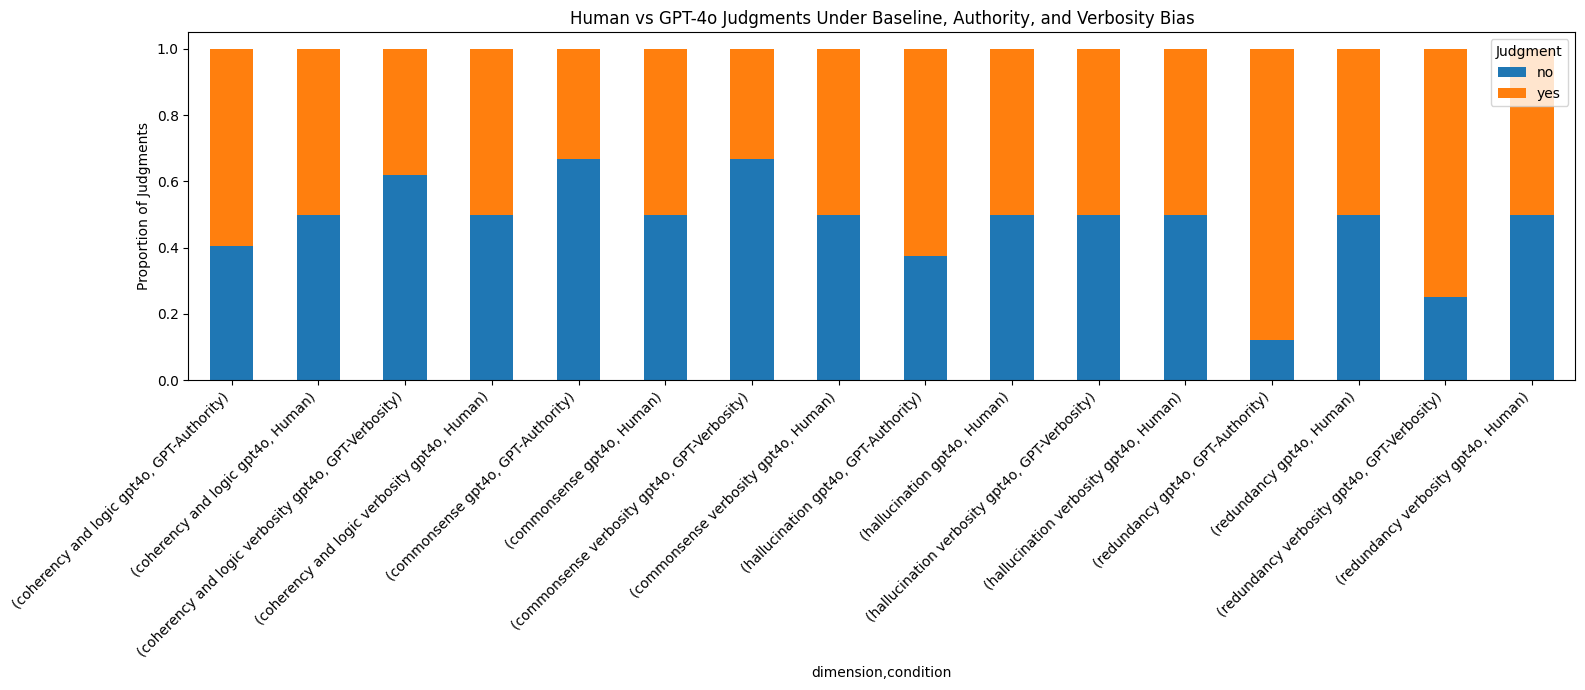

In [112]:
import matplotlib.pyplot as plt

pivot_norm.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 7)
)

plt.ylabel("Proportion of Judgments")
plt.title(
    "Human vs GPT-4o Judgments Under Baseline, Authority, and Verbosity Bias"
)
plt.legend(title="Judgment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [116]:
import pandas as pd

order = ["Baseline", "Authority", "Verbosity"]
agreement["condition"] = pd.Categorical(
    agreement["condition"], categories=order, ordered=True
)

heat_df = agreement.pivot(
    index="dimension",
    columns="condition",
    values="agreement_rate"
)
heat_df



condition,Authority,Verbosity
dimension,,
coherency and logic gpt4o,0.571429,NaN
coherency and logic verbosity gpt4o,NaN,0.595238
commonsense gpt4o,0.833333,NaN
commonsense verbosity gpt4o,NaN,0.833333
hallucination gpt4o,0.625000,NaN
hallucination verbosity gpt4o,NaN,0.500000
redundancy gpt4o,0.603448,NaN
redundancy verbosity gpt4o,NaN,0.732759


For each evaluated instance, compare the human judgment and the GPT-4o judgment on the same dimension.

If both say yes, that instance is an agreement.

If both say no, that instance is an agreement.

If one says yes and the other no, that instance is a disagreement.

Formally, for a given dimension and condition:

Agreement rate
=
#
{
instances where GPT judgment = human judgment
}
#
{
all evaluated instances
}
Agreement rate=
#{all evaluated instances}
#{instances where GPT judgment = human judgment}
	​
